In [112]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
mpl.rcParams.update({'figure.dpi':150})
# path = mpl.rcParams['datapath']
from io import StringIO
import os
import warnings
warnings.filterwarnings('ignore')

#theta, gamma in degrees
thetaR=5
gammaR=30 #Need to be clarified whether it is global
G=9.81 

def readmass(mass_in_name):
    MassProperties={}
    data_in=pd.read_csv(mass_in_name,delimiter='\s+');#这里分隔符是任意多空白字符，包括空格、制表符、换页符
    m_tot=data_in['m_tot'][0]
    CGx=data_in['CGx'][0]
    CGy=data_in['CGy'][0]
    CGz=data_in['CGz'][0]
    Iyy=data_in['Iyy'][0]
    Ixz=data_in['Ixz'][0]
    Izz=data_in['Izz'][0]
    Ixx=data_in['Ixx'][0]
    #Series to floats
    Izx=Ixz;
    MassProperties['m']=m_tot
    MassProperties['Ixx']=Ixx
    MassProperties['CGx']=CGx
    MassProperties['Iyy']=Iyy
    MassProperties['CGz']=CGz
    MassProperties['CGy']=CGy
    MassProperties['Izz']=Izz
    MassProperties['Ixz']=Ixz
    MassProperties['Izx']=Izx
    return MassProperties

In_dir=[
        # 'CG(0.4 0)AoA(-10 +15)b0V12',
        # # 'CG(0.4 -0.03)AoA(-10 +15)b0V12',
        # 'CG(0.4 -0.05)AoA(-10 +15)b0V12','CG(0.4 -0.10)AoA(-10 +15)b0V12',
        # 'CG(0.4 -0.15)AoA(-10 +15)b0V12','CG(0.4 -0.20)AoA(-10 +15)b0V12',
        # 'CG(0.4 -0.25)AoA(-10 +15)b0V12','CG(0.4 -0.30)AoA(-10 +15)b0V12',
        # 'CG(0.4 -0.35)AoA(-10 +15)b0V12','CG(0.4 -0.40)AoA(-10 +15)b0V12',
        # 'CG(0.4 -0.45)AoA(-10 +15)b0V12','CG(0.4 -0.50)AoA(-10 +15)b0V12',

        'CG(0.45 0)AoA(-10 +15)b0V12','CG(0.45 -0.05)AoA(-10 +15)b0V12',
        'CG(0.45 -0.10)AoA(-10 +15)b0V12' ,'CG(0.45 -0.15)AoA(-10 +15)b0V12',
        'CG(0.45 -0.20)AoA(-10 +15)b0V12' ,
        'CG(0.45 -0.25)AoA(-10 +15)b0V12','CG(0.45 -0.30)AoA(-10 +15)b0V12',
        # 'CG(0.45 -0.325)AoA(-10 +15)b0V12',
        'CG(0.45 -0.35)AoA(-10 +15)b0V12','CG(0.45 -0.40)AoA(-10 +15)b0V12',
        'CG(0.45 -0.45)AoA(-10 +15)b0V12','CG(0.45 -0.50)AoA(-10 +15)b0V12'
        # 'CG(0.50 -0.0)AoA(-10 +15)b0V12' ,'CG(0.50 -0.05)AoA(-10 +15)b0V12',
        # 'CG(0.50 -0.10)AoA(-10 +15)b0V12','CG(0.50 -0.15)AoA(-10 +15)b0V12',
        # 'CG(0.50 -0.20)AoA(-10 +15)b0V12','CG(0.50 -0.25)AoA(-10 +15)b0V12',
        # 'CG(0.50 -0.30)AoA(-10 +15)b0V12' 
        ]
mass_in_name="Mass_Inertia_out.txt"#这里改输入文件名
# MassProperties= readmass(mass_in_name)
#
class StabDataWC:  #Each Working Condition
    def __init__(self,Refs,Coefs):
        self.Refs=Refs
        self.Coefs=Coefs
        # print(Refs,Coefs)
    def __LateralData__(self,MassProps,thetaRinDegrees,gammaRinDegrees):
        self.EigValuesLtrl,self.EigVectorsLtrl,self.A2 = CalLateral(self.Refs,self.Coefs,MassProps,thetaRinDegrees,gammaRinDegrees)
        # print(self.EigValues)
    def __LongitudinalData__(self,MassProps,thetaRinDegrees,gammaRinDegrees):
        self.EigValuesLgl,self.EigVectorsLgl,self.A1= CalLongitudinal(self.Refs,self.Coefs,MassProps,thetaRinDegrees,gammaRinDegrees)

class StabDataCon: #Each Configuration
    def __init__(self,MassProp,StabDataList,dirname):
        self.MassProp=MassProp
        self.StabDataList=StabDataList
        self.dirname=dirname

In [113]:
stabFileName='PR6_001_DegenGeom.stab'


def ReadCase(linescache):
    varnames=[]
    RefVars={}
    coeflines=[];
    for iline in range(len(linescache)):
        if (linescache[iline].startswith('*')
            or linescache[iline].startswith('#')
            or linescache[iline].startswith('\n')):
            continue
        elif linescache[iline].startswith('Case'):
            iline+=10;
            # lines = lines[11:]
            continue
        elif linescache[iline].startswith('Coef'):
            coeflines.append(linescache[iline])
            for jline in range(1,17):
                if (linescache[iline+jline].startswith('#')
                    or linescache[iline+jline].startswith('\n')):
                    continue;
                else:
                    coeflines.append(linescache[iline+jline])
            iline+=jline
            # print(iline)
        else:
            parts = linescache[iline].split()
            # print(parts,'\n')
            # var_name = parts[0]
            # var_value = float(parts[1])
            # exec('parts[0]=float(parts[1])')
            varnames.append(parts[0]);
            RefVars[parts[0]]=parts[1];
    # print(RefVars)
    # print(coeflines)
    coefs= pd.read_csv(StringIO(''.join(coeflines)), sep="\s+",index_col="Coef")
    # print(coefs.info())
    return RefVars, coefs


# Read data from the file
def ReadStabFile(stbname):
    StabData=[];
    with open(stbname, 'r') as file:
        lines = file.readlines()


    ncase=0;
    # print(len(lines)//57)
    for iline in range(0,len(lines)):
        if lines[iline].startswith('*'):
            ncase+=1;
            cache1, cache2=ReadCase(lines[iline:iline+57])
            StabData.append(StabDataWC(cache1,cache2))
            iline+=50;
        else:
            # iline+=50;
            continue
    
    return StabData



In [114]:
def CalLateral(Refs,Coefs,MassProps,thetaRinDegrees,gammaRinDegrees):
    thetaR=thetaRinDegrees      * math.pi/180
    gammaR=gammaRinDegrees      * math.pi/180
    alphaR= float(Refs['AoA_']) * math.pi/180
    VR=     float(Refs['Vinf_'])
    rhoR=   float(Refs['Rho_'])
    # rhoR=   1.225
    qR=     0.5*rhoR*VR**2
    cR=     float(Refs['Cref_'])
    bR=     float(Refs['Bref_'])
    SR=     float(Refs['Sref_'])
    # print(rhoR)

    Ixz=MassProps['Ixz']
    Ixx=MassProps['Ixx']
    Iyy=MassProps['Iyy']
    Izz=MassProps['Izz']
    m=  MassProps['m']  
    Izx=Ixz
    
    Cal_L_bar=lambda Li,Ni:(Li+(Ixz/Izz)*Ni)/(Ixx-Ixz**2/Izz)
    Cal_N_bar=lambda Li,Ni:(Ni+(Ixz/Ixx)*Li)/(Izz-Ixz**2/Ixx)
    Cyb=Coefs.loc['CFy','Beta']  ;Yb_bar=Cyb*qR*SR/m /VR;
    Cyp=Coefs.loc['CFy','p']   ;Yp_bar=Cyp*qR*SR/m /VR * bR /(2*VR)
    Cyr=Coefs.loc['CFy','r']   ;Yr_bar=Cyr*qR*SR/m /VR * bR /(2*VR)
    Cnb=Coefs.loc['CMn','Beta']   ;Nb=Cnb*qR*SR*bR;
    Clb=Coefs.loc['CMl','Beta']  ;Lb=Clb*qR*SR*bR;
    Lb_bar=Cal_L_bar(Lb,Nb);Nb_bar=Cal_N_bar(Lb,Nb);
    # print(Lb_bar,Nb_bar)
    Cnp=Coefs.loc['CMn','p']  ;Np=Cnp*qR*SR*bR* bR/(2*VR)
    Clp=Coefs.loc['CMl','p']  ;Lp=Clp*qR*SR*bR* bR/(2*VR)
    Lp_bar=Cal_L_bar(Lp,Np);Np_bar=Cal_N_bar(Lp,Np)
    Cnr=Coefs.loc['CMn','r'] ;Nr=Cnr*qR*SR*bR* bR/(2*VR)
    Clr=Coefs.loc['CMl','r'];Lr=Clr*qR*SR*bR* bR/(2*VR)
    Lr_bar=Cal_L_bar(Lr,Nr);Nr_bar=Cal_N_bar(Lr,Nr)

    A2=np.asmatrix([[Yb_bar, alphaR+Yp_bar, Yr_bar - 1, G*math.cos(thetaR)/VR],
            [Lb_bar, Lp_bar, Lr_bar, 0],
            [Nb_bar, Np_bar, Nr_bar, 0],
            [0, 1, math.tan(thetaR), 0]])
    # print(A2)
    print('CGz',MassProps['CGz'],'AoA',Refs['AoA_'])
    print('spiral',Lb_bar*Nr_bar- Lr_bar*Nb_bar)
    print('dutch roll',Nb_bar/Lb_bar)

    eigValue, featureVector = np.linalg.eig(A2);
    return eigValue, featureVector, A2

# thetaRinDegrees = thetaR


In [115]:
def CalLongitudinal(Refs,Coefs,MassProps,thetaRinDegrees,gammaRinDegrees):
    thetaR=thetaRinDegrees      * math.pi/180
    gammaR=gammaRinDegrees      * math.pi/180
    alphaR= float(Refs['AoA_']) * math.pi/180
    VR=     float(Refs['Vinf_'])
    rhoR=   float(Refs['Rho_'])
    # rhoR=   1.225
    qR=     0.5*rhoR*VR**2
    cR=     float(Refs['Cref_'])
    bR=     float(Refs['Bref_'])
    SR=     float(Refs['Sref_'])
    C_LR=   Coefs.loc['CL','Total']
    C_DR=   Coefs.loc['CD','Total']
    C_mR=   Coefs.loc['CMm','Total']
    # T_R=    C_DR * qR * SR;
    T_R = 0;
    # print(rhoR)

    Ixz=MassProps['Ixz']
    Ixx=MassProps['Ixx']
    Iyy=MassProps['Iyy']
    Izz=MassProps['Izz']
    m=  MassProps['m']  
    Izx=Ixz
    
    C_DV=   Coefs.loc['CD','U']
    C_LV=   Coefs.loc['CL','U']
    X_V=    -(C_DV+2*C_DR)* qR *SR /m /VR; #Ignore T_V
    Z_V=    (C_LV+2*C_LR)*qR*SR /m /VR /VR #Ignore T_V
    C_La=   Coefs.loc['CL','Alpha'];Z_a=(C_DR+C_La)*qR*SR/m /VR;
    C_Lq=   Coefs.loc['CL','q'];Z_q=C_Lq*(cR/2 /VR) *qR*SR/m/VR;
    C_mV=   Coefs.loc['CMm','U'];M_V_bar=(C_mV+2*C_mR)*qR*SR*cR /VR /Iyy;
    C_mq=   Coefs.loc['CMm','q'];M_q_bar=C_mq*(cR/2 /VR)*qR*SR*cR/Iyy;
    C_Da=   Coefs.loc['CD','Alpha'];X_a=(-T_R*math.sin(alphaR)-C_Da*qR*SR)/m
    C_ma=   Coefs.loc['CMm','Alpha'];M_a_bar=C_ma*qR*SR*cR/Iyy;

    A1=np.asmatrix([[X_V,X_a+G, 0, -G*math.cos(gammaR)],
            [-Z_V, -Z_a, 1, -G*math.sin(gammaR)],
            [M_V_bar, M_a_bar, M_q_bar, 0],
            [0, 0, 1, 0]])
    # print(A1)

    eigValue, featureVector = np.linalg.eig(A1);
    return eigValue, featureVector, A1

# thetaRinDegrees = thetaR


In [116]:
def cal_w_c(eig):
    eigR,eigI=eig.real,eig.imag;
    w=math.sqrt(eigR**2+eigI**2)
    c=-eigR/w
    return w,c

In [117]:
#Calculate
def Cal_Lat_Lgl(MassProperties,StabData,thetaR,gammaR):
    for stabcase in StabData:
        stabcase.__LateralData__(MassProperties,thetaR,gammaR)
        stabcase.__LongitudinalData__(MassProperties,thetaR,gammaR)

In [118]:
DataCon=[]

for icon in range(len(In_dir)):
    massname_with_dir='./'+In_dir[icon]+'/'+mass_in_name
    stabname_with_dir='./'+In_dir[icon]+'/'+stabFileName
    # print(massname_with_dir)
    massProp=readmass(massname_with_dir)
    stabCases=ReadStabFile(stabname_with_dir)
    DataCon.append(StabDataCon(massProp,stabCases,In_dir[icon]))
    Cal_Lat_Lgl(DataCon[icon].MassProp,DataCon[icon].StabDataList,thetaR,gammaR)
    # print(DataCon[icon].StabDataList[15].Refs)

# print(DataCon[4].StabDataList)
    

CGz 0.0 AoA -10.0000000
spiral 145.43101895079974
dutch roll 0.2805590663498254
CGz 0.0 AoA -9.0000000
spiral 155.7057248179097
dutch roll 0.3616858779751481
CGz 0.0 AoA -8.0000000
spiral 159.9828755213349
dutch roll 0.523420939669045
CGz 0.0 AoA -7.0000000
spiral 161.83358217302157
dutch roll 0.822617551954387
CGz 0.0 AoA -6.0000000
spiral 159.05352529109507
dutch roll 1.9378703223582259
CGz 0.0 AoA -5.0000000
spiral 145.71963964972534
dutch roll -113.97925821246554
CGz 0.0 AoA -4.0000000
spiral 126.37722756440203
dutch roll -2.447955595415481
CGz 0.0 AoA -3.0000000
spiral 104.032720109038
dutch roll -1.3678551303013433
CGz 0.0 AoA -2.0000000
spiral 73.47435744872911
dutch roll -1.1165284699378901
CGz 0.0 AoA -1.0000000
spiral 40.08616480704324
dutch roll -1.0046581482074166
CGz 0.0 AoA 0.0000000
spiral 0.4175080926523691
dutch roll -1.023838786138733
CGz 0.0 AoA 1.0000000
spiral -37.86328123806617
dutch roll -1.0315856048036791
CGz 0.0 AoA 2.0000000
spiral -76.31467316684731
dutch ro

CGz -0.10044 AoA -10.0000000
spiral 113.15243461899917
dutch roll 0.5886123631425881
CGz -0.10044 AoA -9.0000000
spiral 119.72648118911458
dutch roll 0.7876063799663088
CGz -0.10044 AoA -8.0000000
spiral 122.2954908440692
dutch roll 1.3061842038291742
CGz -0.10044 AoA -7.0000000
spiral 123.1015584993394
dutch roll 3.1650195885901007
CGz -0.10044 AoA -6.0000000
spiral 120.70859825630421
dutch roll -5.611293213396763
CGz -0.10044 AoA -5.0000000
spiral 110.84407598437653
dutch roll -1.7222338299240671
CGz -0.10044 AoA -4.0000000
spiral 96.70958077560886
dutch roll -1.1016390685270625
CGz -0.10044 AoA -3.0000000
spiral 80.49491590302567
dutch roll -0.8429112170121001
CGz -0.10044 AoA -2.0000000
spiral 58.40952968361667
dutch roll -0.7489636333545147
CGz -0.10044 AoA -1.0000000
spiral 34.32081478983889
dutch roll -0.7001031298509062
CGz -0.10044 AoA 0.0000000
spiral 5.588154301173944
dutch roll -0.707842111739281
CGz -0.10044 AoA 1.0000000
spiral -21.92249848379577
dutch roll -0.71138873646

In [119]:
iccfg=6;iccase=15
print(DataCon[iccfg].StabDataList[iccase].A1)
print(DataCon[iccfg].StabDataList[iccase].Refs)
print(np.linalg.eig(DataCon[iccfg].StabDataList[iccase].A1))
print('---')

for j in range(4):
            w,c= cal_w_c(DataCon[iccfg].StabDataList[iccase].EigValuesLtrl[j])
            # if(icon >-1):
            print(w,c)
print('---')
for j in range(4):
            w,c= cal_w_c(DataCon[iccfg].StabDataList[iccase].EigValuesLgl[j])
            # if(icon >-1):
            print(w,c)

[[ -0.13393701   2.97133383   0.          -8.49570921]
 [ -0.17672489 -11.82467555   1.          -4.905     ]
 [ -0.16456206 -52.67031776  -0.65825582   0.        ]
 [  0.           0.           1.           0.        ]]
{'Sref_': '0.2730000', 'Cref_': '0.2100000', 'Bref_': '1.3000000', 'Xcg_': '0.0450000', 'Ycg_': '0.0001750', 'Zcg_': '-0.3000000', 'Mach_': '0.0000000', 'AoA_': '5.0000000', 'Beta_': '0.0000000', 'Rho_': '1.2255000', 'Vinf_': '12.0000000', 'Roll__Rate': '+1.000', 'Pitch_Rate': '+1.000', 'Yaw___Rate': '+1.000', 'Base_Aero': '+0.000', 'Alpha': '+1.000', 'Beta': '+1.000', 'Mach': '+0.100', 'CFx': '-0.0096028', 'CFy': '0.0000000', 'CFz': '0.3968445', 'CMx': '-0.0000534', 'CMy': '-0.0184581', 'CMz': '-0.0000013', 'CL': '0.3961713', 'CD': '0.0250210', 'CS': '0.0000000', 'CMl': '0.0000534', 'CMm': '-0.0184581', 'CMn': '0.0000013', 'SM': '0.2241379', 'X_np': '0.0920690'}
EigResult(eigenvalues=array([-7.57287693+6.58412722j, -7.57287693-6.58412722j,
        0.10464956+0.j      

In [120]:
#Plot function
def PlotStabScatter(fig,EigValues,
                    color,mkr
                    ):
    # for ite in EigValues:
    #     fig.scatter(ite.real, ite.imag,
    #                 c=color,
    #                 marker='x')
    plt.plot(EigValues.real, EigValues.imag,
                 marker=mkr, c=color,ms=5,linewidth=0)
    return

cmapBW30=plt.get_cmap('binary',30)
colorBW30=cmapBW30([range(30)])
print(colorBW30[0][10][0:3])
viridis= mpl.colormaps['viridis_r'].resampled(40)
colorVR32= viridis(range(40))
# # colorBW30=colorBW30[:,0:3]



mkr_list=['x','^','o','1','*','d','s','+','h','p','p']
lin_list=['-',':','-.','--']
lbl_list=['$z_{CG}=0$','$z_{CG}=24\%MAC$','$z_{CG}=48\%MAC$',
          '$z_{CG}=72\%MAC$','$z_{CG}=95\%MAC$','$z_{CG}=119\%MAC$',
          '$z_{CG}=143\%MAC$','$z_{CG}=167\%MAC$','$z_{CG}=190\%MAC$',
          '$z_{CG}=214\%MAC$','$z_{CG}=238\%MAC$']

[0.65517241 0.65517241 0.65517241]


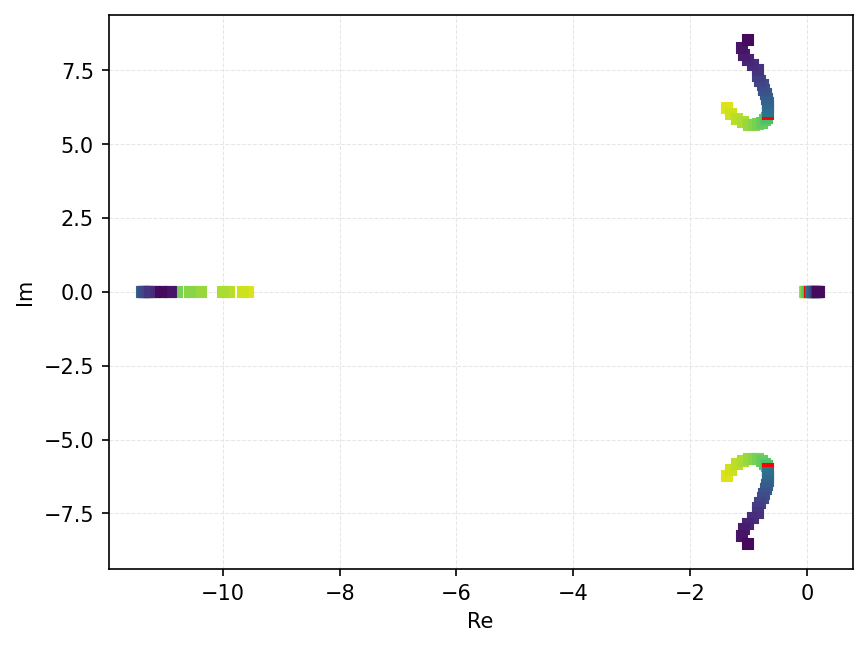

In [121]:
fig, ax1 = plt.subplots()

for icon in [6]:#range (6,7):
    StabData=DataCon[icon].StabDataList;
    for icase in range(0,len(StabData)):
        # range(15,len(StabData)-10):
        stabcase=StabData[icase]
        # CaseColor=colorBW30[0][icase+3][0:3]
        CaseColor=colorVR32[icase+2]#[0:3]
        if(icase==10):
            CaseColor='r'
        elif(icase>10):
            CaseColor=colorVR32[icase+13]
        # plt.plot(EigValues.real, EigValues.imag,
        #          mkr, color=color,ms=4)
        PlotStabScatter(ax1,stabcase.EigValuesLtrl,
                        CaseColor,mkr_list[icon % 10]
                        )
        
        # plt.plot(stabcase.EigValuesLtrl.real,stabcase.EigValuesLtrl.imag,
        #          marker=mkr_list[icon % 7], color=CaseColor,ms=4,linewidth=0)
# ax1.legend(labels=lbl_list)
# ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = [0.9,0.9,0.9], linestyle = '--', linewidth = 0.5)
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()
# figFileName='P6_CG('+str(round(MassProperties['CGx'],3))+' '+str(round(MassProperties['CGz'],3))+')_Lateral.png'
# print(figFileName)
# plt.savefig(figFileName,bbox_inches='tight')

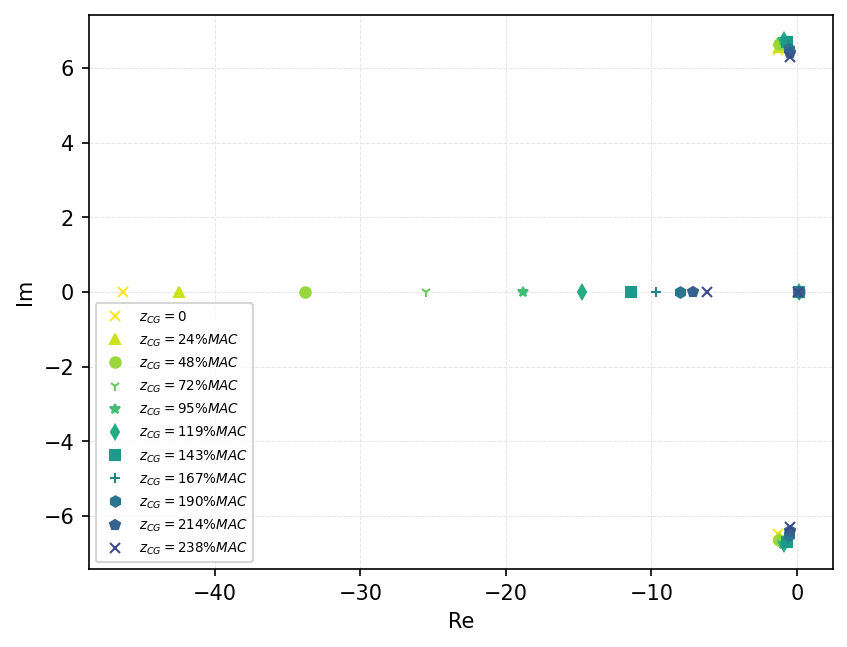

In [122]:
fig, ax1 = plt.subplots()

for icon in range (11):
    StabData=DataCon[icon].StabDataList;
    for icase in [15]:#range(0,len(StabData)):
        # range(15,len(StabData)-10):
        stabcase=StabData[icase]
        # CaseColor=colorBW30[0][icase+3][0:3]
        CaseColor=colorVR32[
                            icon*3
                            ]
        # plt.plot(EigValues.real, EigValues.imag,
        #          mkr, color=color,ms=4)
        PlotStabScatter(ax1,stabcase.EigValuesLtrl,
                        CaseColor,mkr_list[icon % 10]
                        )
        
        # plt.plot(stabcase.EigValuesLtrl.real,stabcase.EigValuesLtrl.imag,
        #          marker=mkr_list[icon % 7], color=CaseColor,ms=4,linewidth=0)
ax1.legend(labels=lbl_list,fontsize=6.5)
# ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = [0.9,0.9,0.9], linestyle = '--', linewidth = 0.5)
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()
# figFileName='P6_CG('+str(round(MassProperties['CGx'],3))+' '+str(round(MassProperties['CGz'],3))+')_Lateral.png'
# print(figFileName)
# plt.savefig(figFileName,bbox_inches='tight')

17.80764146819695 1.0
0.3077442917915521 1.0
4.569740278367708 -0.6148280150657759
4.569740278367708 -0.6148280150657759
[[ 0.25141994+0.j         -0.99916886+0.j         -0.342113  -0.33373972j
  -0.342113  +0.33373972j]
 [-0.22681949+0.j         -0.01249858+0.j         -0.0385512 -0.04678469j
  -0.0385512 +0.04678469j]
 [ 0.93944549+0.j          0.01141207+0.j         -0.85604293+0.j
  -0.85604293-0.j        ]
 [-0.05275519+0.j         -0.03708296+0.j         -0.11517486+0.14773878j
  -0.11517486-0.14773878j]] [-17.80764147+0.j          -0.30774429+0.j
   2.80960434+3.60397692j   2.80960434-3.60397692j]
17.10482043766333 1.0
0.3100809202541283 1.0
4.400367547398597 -0.5952362972607225
4.400367547398597 -0.5952362972607225
[[ 0.25876634+0.j         -0.9992711 +0.j         -0.36827594-0.34689866j
  -0.36827594+0.34689866j]
 [-0.24291261+0.j         -0.01075363+0.j         -0.0394958 -0.0496807j
  -0.0394958 +0.0496807j ]
 [ 0.93330394+0.j          0.01084819+0.j         -0.83884788+0.j

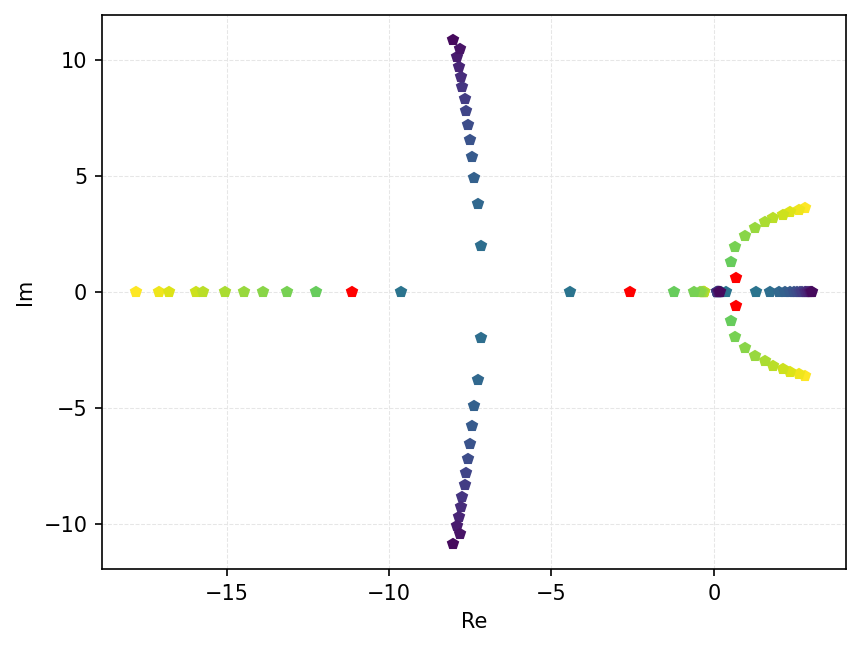

In [123]:
fig, ax1 = plt.subplots()

for icon in [9]: #range(1,2):
    StabData=DataCon[icon].StabDataList;
    for icase in        range(len(StabData)):
                            #11,len(StabData)-8,5):
                            #    ,len(StabData)-8):
        stabcase=StabData[icase]
        # CaseColor=colorBW30[0][2*icase-25][0:3]
        CaseColor=colorVR32[
                            icase
                            ]
        if(icase==10):
            CaseColor='r'
        elif(icase>10):
            CaseColor=colorVR32[icase+13]
        PlotStabScatter(ax1,stabcase.EigValuesLgl,
                        CaseColor,
                        # 'x'
                        mkr_list[icon % 10]
                        )
        for j in range(4):
            w,c= cal_w_c(stabcase.EigValuesLgl[j])
            # if(icon >-1):
            print(w,c)
        # if(icase %5 == 0) :
        print(stabcase.EigVectorsLgl,stabcase.EigValuesLgl)
# ax1.legend(labels=lbl_list)
# ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = [0.9,0.9,0.9], linestyle = '--', linewidth = 0.5)
plt.xlabel('Re')
plt.ylabel('Im')
# plt.xlim(-0.2,4)
# plt,ylim(-0.1,0.1)
plt.show()

10.363783405010956 1.0
3.832054579310127 1.0
0.11302266760279812 1.0
1.059518745188426 -1.0
[[ 3.97490132e-01 -6.89836257e-01 -9.99963822e-01 -9.84762992e-01]
 [-6.63600137e-01  2.01177335e-01  7.59743477e-03 -2.69256255e-02]
 [-6.30818194e-01  6.72917151e-01 -4.29624108e-04  1.24942932e-01]
 [ 6.08675586e-02 -1.75602183e-01  3.80122074e-03  1.17924230e-01]] [-10.36378341  -3.83205458  -0.11302267   1.05951875]
7.9938357711122086 0.9306402718360327
7.9938357711122086 0.9306402718360327
0.05870385594377881 -1.0
1.5927482541982594 -1.0
[[-0.27859671-0.07160891j -0.27859671+0.07160891j -0.9998019 +0.j
  -0.94814049+0.j        ]
 [ 0.25230713-0.11987509j  0.25230713+0.11987509j  0.00100083+0.j
  -0.03383626+0.j        ]
 [ 0.90900842+0.j          0.90900842-0.j          0.00116493+0.j
   0.26766311+0.j        ]
 [-0.10582652-0.04161185j -0.10582652+0.04161185j  0.01984426+0.j
   0.16805111+0.j        ]] [-7.4393855 +2.92522714j -7.4393855 -2.92522714j  0.05870386+0.j
  1.59274825+0.j      

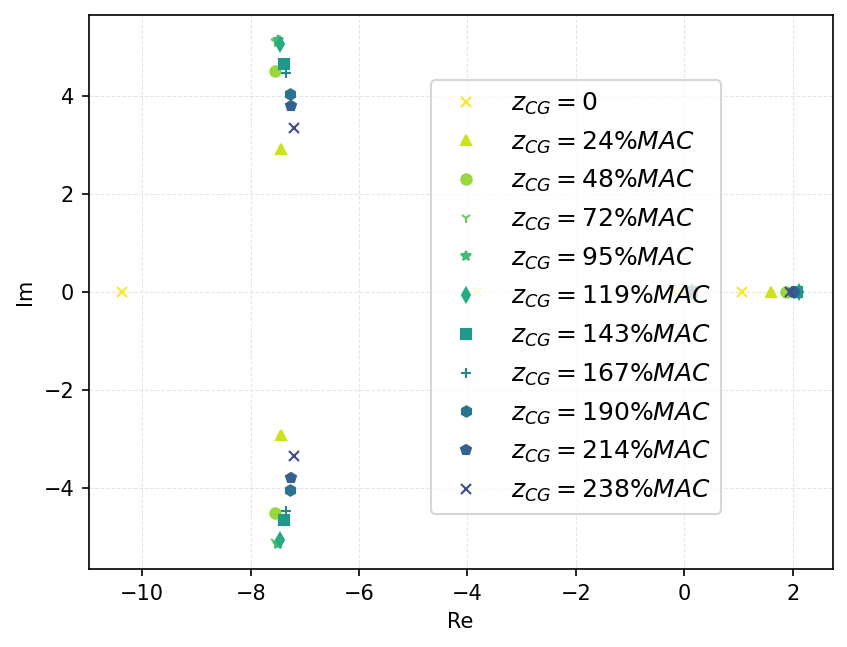

In [124]:
fig, ax1 = plt.subplots()

for icon in range(11):
    StabData=DataCon[icon].StabDataList;
    for icase in    [13]:     #range(len(StabData)):
                            #11,len(StabData)-8,5):
                            #    ,len(StabData)-8):
        stabcase=StabData[icase]
        # CaseColor=colorBW30[0][2*icase-25][0:3]
        CaseColor=colorVR32[
                            icon*3
                            ]
        # if(icon==10):
        #     CaseColor='r'
        # elif(icon>10):
        #     CaseColor=colorVR32[icase+13]
        PlotStabScatter(ax1,stabcase.EigValuesLgl,
                        CaseColor,
                        # 'x'
                        mkr_list[icon % 10]
                        )
        for j in range(4):
            w,c= cal_w_c(stabcase.EigValuesLgl[j])
            # if(icon >-1):
            print(w,c)
        # if(icase %5 == 0) :
        print(stabcase.EigVectorsLgl,stabcase.EigValuesLgl)
ax1.legend(labels=lbl_list,fontsize=12
           ,loc=(0.46,0.1)
           )
# ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = [0.9,0.9,0.9], linestyle = '--', linewidth = 0.5)
plt.xlabel('Re')
plt.ylabel('Im')
# plt.xlim(-0.2,4)
# plt,ylim(-0.1,0.1)
plt.show()

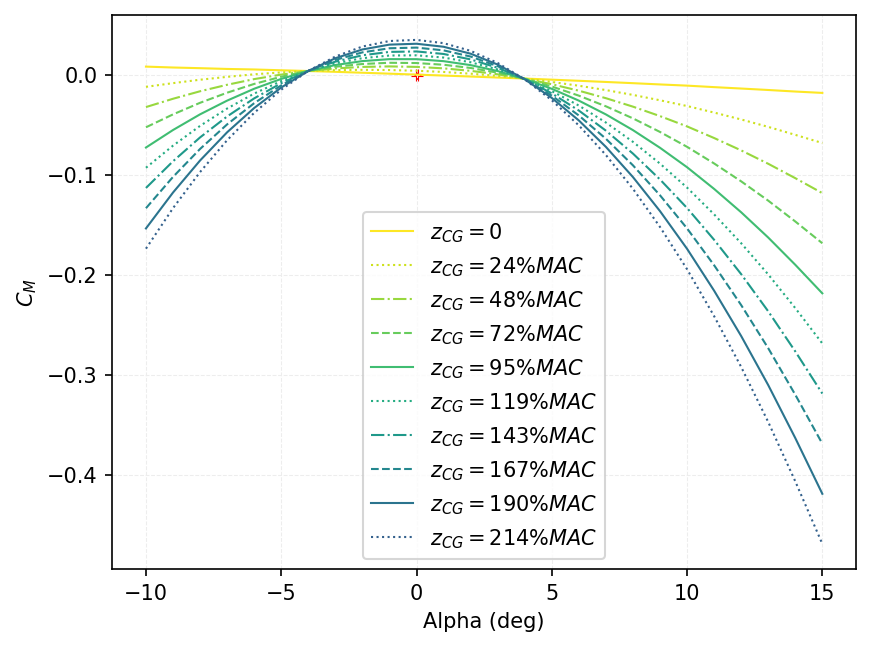

In [125]:
fig, ax1 = plt.subplots()


for icon in range (10):
    StabData=DataCon[icon].StabDataList;
    xdata=[];ydata=[]
    for icase in range(len(StabData)):
        stabcase=StabData[icase]
        xdata.append(float(stabcase.Refs['AoA_']))
        ydata.append(float(stabcase.Refs['CMy']))
        # # if(icase==15):
        # #     CaseColor='g'
        # PlotStabScatter(ax1,stabcase.EigValuesLgl,
        #                 CaseColor,mkr_list[icon % 7]
        #                 )
    # CaseColor=colorBW30[0][
    #     icon*2+7
    #     # int(1.8*icon)
    #     ][0:3]
    CaseColor=colorVR32[3*icon]
    plt.plot(xdata,ydata,c=CaseColor,linestyle=lin_list[icon%4],
            linewidth=1
             )
ax1.legend(labels=lbl_list)
ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = colorBW30[0][2], linestyle = '--', linewidth = 0.5)
plt.xlabel('Alpha (deg)')
plt.ylabel('$C_M$')
plt.show()

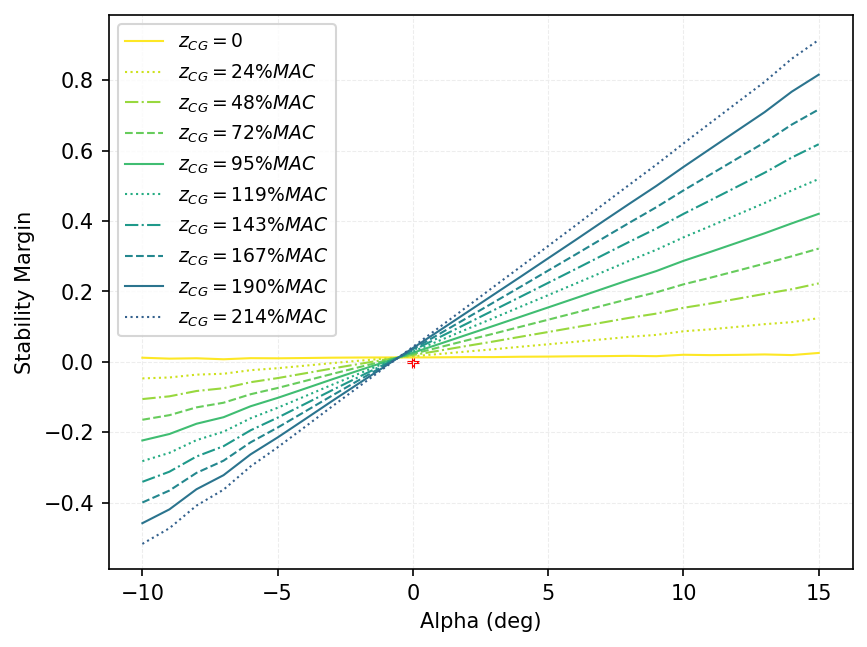

In [126]:
fig, ax1 = plt.subplots()


for icon in range (10):
    StabData=DataCon[icon].StabDataList;
    xdata=[];ydata=[]
    for icase in range(len(StabData)):
        stabcase=StabData[icase]
        xdata.append(float(stabcase.Refs['AoA_']))
        ydata.append(float(stabcase.Refs['SM']))
        # # if(icase==15):
        # #     CaseColor='g'
        # PlotStabScatter(ax1,stabcase.EigValuesLgl,
        #                 CaseColor,mkr_list[icon % 7]
        #                 )
    # CaseColor=colorBW30[0][
    #     icon*2+7
    #     # int(1.8*icon)
    #     ][0:3]
    CaseColor=colorVR32[3*icon]
    plt.plot(xdata,ydata,c=CaseColor,linestyle=lin_list[icon%4],
            linewidth=1
             )
ax1.legend(labels=lbl_list,fontsize=9)
ax1.scatter(0,0,c='r',marker='+')
plt.grid(color = colorBW30[0][2], linestyle = '--', linewidth = 0.5)
plt.xlabel('Alpha (deg)')
plt.ylabel('Stability Margin')
plt.show()

In [127]:
# fig, ax1 = plt.subplots()

locator="'CMl','p'"
print(locator)

for icon in range (7):
    StabData=DataCon[icon].StabDataList;
    xdata=[];ydata=[]
    
    for icase in range(len(StabData)):
        stabcase=StabData[icase]
        xdata.append(float(stabcase.Refs['AoA_']))
        ydata.append(float(stabcase.Refs['CMy']))
        if(icase==15):
            
            print(stabcase.Coefs.loc['CL','Alpha'])
        #     CaseColor='g'
        # PlotStabScatter(ax1,stabcase.EigValuesLgl,
        #                 CaseColor,mkr_list[icon % 7]
    #     #                 )
#     # CaseColor=colorBW30[0][int(1.5*icon)-2][0:3]
#     # plt.plot(xdata,ydata,c=CaseColor,linestyle='-',
#             #  lin_list[icon % 4]
#             linewidth=1
#              )
# ax1.legend(labels=lbl_list)
# ax1.scatter(0,0,c='r',marker='+')
# plt.grid(color = colorBW30[0][2], linestyle = '--', linewidth = 0.5)
# plt.xlabel('AoA')
# plt.ylabel('Cm')
# plt.show()

'CMl','p'
4.3929579
4.3929509
4.3929598
4.3929557
4.3929487
4.3929511
4.3929543


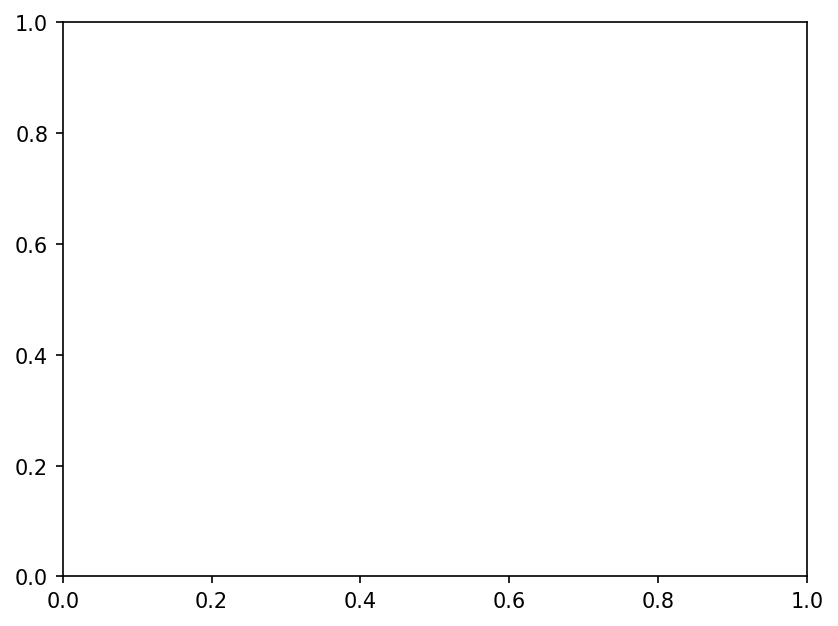

In [128]:
fig, ax1 = plt.subplots()


for icase in range(
                   len(StabData)
                   ):
    stabcase=StabData[icase]
    
    CaseColor=colorBW30[0][icase+4][0:3]
    # if(icase==15):
    #     CaseColor='g'
    # PlotStabScatter(ax1,stabcase.EigValuesLgl,
    #                 CaseColor,
    #                 )

# ax1.scatter(0,0,c='r',marker='+')
# plt.grid(color = colorBW30[0][2], linestyle = '--', linewidth = 0.5)
# plt.show()
# figFileName='P6_CG('+str(round(MassProperties['CGx'],3))+' '+str(round(MassProperties['CGz'],3))+')_Longitudinal.png'
# print(figFileName)
# plt.savefig(figFileName,bbox_inches='tight')

In [129]:
# StabData[15].Refs['AoA_']
print(StabData[15].EigValuesLgl)
print(StabData[15].Refs)
print(StabData[15].Coefs)
print(StabData[15].A2)

[-7.57287693+6.58412722j -7.57287693-6.58412722j  0.10464956+0.j
  2.42423592+0.j        ]
{'Sref_': '0.2730000', 'Cref_': '0.2100000', 'Bref_': '1.3000000', 'Xcg_': '0.0450000', 'Ycg_': '0.0001750', 'Zcg_': '-0.3000000', 'Mach_': '0.0000000', 'AoA_': '5.0000000', 'Beta_': '0.0000000', 'Rho_': '1.2255000', 'Vinf_': '12.0000000', 'Roll__Rate': '+1.000', 'Pitch_Rate': '+1.000', 'Yaw___Rate': '+1.000', 'Base_Aero': '+0.000', 'Alpha': '+1.000', 'Beta': '+1.000', 'Mach': '+0.100', 'CFx': '-0.0096028', 'CFy': '0.0000000', 'CFz': '0.3968445', 'CMx': '-0.0000534', 'CMy': '-0.0184581', 'CMz': '-0.0000013', 'CL': '0.3961713', 'CD': '0.0250210', 'CS': '0.0000000', 'CMl': '0.0000534', 'CMm': '-0.0184581', 'CMn': '0.0000013', 'SM': '0.2241379', 'X_np': '0.0920690'}
         Total     Alpha      Beta         p         q         r  \
Coef                                                               
CFx  -0.009603 -0.644172 -0.002338 -0.030978 -0.303384 -0.001842   
CFy   0.000000 -0.000003 -0.26322